## 1. Установите и импортируйте необходимые зависимости

In [ ]:
!pip install matplotlib torch torchvision datasets
!pip install "cleanlab[image]

In [ ]:
dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "datasets", "cleanvision"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install "cleanlab[image]"  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

# Suppress benign warnings:
import warnings
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import math
import time
import multiprocessing

from cleanlab import Datalab
from datasets import load_dataset

## 2. Получите и нормализуйте набор данных Fashion-MNIST.

На данном этапе я пытался выбрать emnist или qminst, но у меня не получилось их выбрать. Поэтому мне посоветавали взять датасет mnist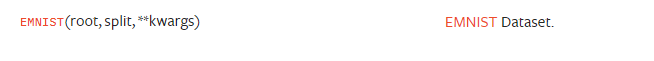

In [ ]:
dataset = load_dataset("mnist", split="train")
dataset

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

Get number of classes in the dataset

In [ ]:
num_classes = len(dataset.features["label"].names)
num_classes

10

In [ ]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format("torch")


# Apply transformations
def normalize(example):
    example["image"] = (example["image"] / 255.0).unsqueeze(0)
    return example


transformed_dataset = transformed_dataset.map(normalize, num_proc=multiprocessing.cpu_count())

Map (num_proc=2):   0%|          | 0/60000 [00:00<?, ? examples/s]

In [ ]:
torch_dataset = TensorDataset(transformed_dataset["image"], transformed_dataset["label"])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(nn.LazyLinear(128), nn.ReLU())
        self.output = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.embeddings(x)
        x = self.output(x)
        return x

    def embeddings(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.linear(x)
        return x

In [ ]:
# This (optional) cell is hidden from docs.cleanlab.ai

SEED = 123  # for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(SEED)

<details><summary>Helper methods for cross validation **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data["image"].to(device), data["label"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)
```
</details>

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)

## 4. Подготовьте набор данных для перекрестной проверки в K-кратном размере.

Чтобы обнаружить проблемы с метками на основе `pred_probs`, мы рекомендуем прогнозы за пределами выборки, которые можно получить [с помощью K-кратной перекрестной проверки] (https://docs.cleanlab.ai/stable/tutorials/pred_probs_cross_val.html ). Чтобы обеспечить быстрое выполнение этого задания, установим здесь небольшие значения для K и других важных гиперпараметров обучения нейронной сети. Используйте большие значения, чтобы получить хорошие результаты на практике!

In [ ]:
K = 3  # Количество сверток перекрестной проверки. Установите здесь небольшое значение, чтобы обеспечить быстрое время выполнения. На практике мы рекомендуем 5 или 10 для более точных оценок.
n_epochs = 2  # Количество эпох для обучения модели. Установите здесь небольшое значение для быстрого выполнения, на практике вам следует использовать большее значение.
patience = 2  # Параметр для быстрой остановки. Если точность проверки не улучшится в течение этого количества эпох, обучение остановится.
train_batch_size = 64  # Размер пакета для обучения
test_batch_size = 512  # Размер пакета для тестирования
num_workers = multiprocessing.cpu_count()  # Number of workers for data loaders

# Create k splits of the dataset
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
splits = kfold.split(transformed_dataset, transformed_dataset["label"])

train_id_list, test_id_list = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

In [ ]:
pred_probs_list, embeddings_list = [], []
embeddings_model = None

for i in range(K):
    print(f"\nTraining on fold: {i+1} ...")

    # Create train and test sets and corresponding dataloaders
    trainset = Subset(torch_dataset, train_id_list[i])
    testset = Subset(torch_dataset, test_id_list[i])

    trainloader = DataLoader(
        trainset,
        batch_size=train_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    testloader = DataLoader(
        testset, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    # Train model
    model = train(trainloader, testloader, n_epochs, patience)
    if embeddings_model is None:
        embeddings_model = model

    # Compute out-of-sample embeddings
    print("Computing feature embeddings ...")
    fold_embeddings = compute_embeddings(embeddings_model, testloader)
    embeddings_list.append(fold_embeddings)

    print("Computing predicted probabilities ...")
    # Compute out-of-sample predicted probabilities
    fold_pred_probs = compute_pred_probs(model, testloader)
    pred_probs_list.append(fold_pred_probs)

print("Finished Training")


# Combine embeddings and predicted probabilities from each fold
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()


Training on fold: 1 ...
epoch: 1 loss: 0.179 test acc: 97.430 time_taken: 17.432
epoch: 2 loss: 0.061 test acc: 98.165 time_taken: 12.633
Computing feature embeddings ...


100%|██████████| 40/40 [00:01<00:00, 21.13it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:01<00:00, 22.22it/s]


Training on fold: 2 ...


epoch: 1 loss: 0.173 test acc: 97.920 time_taken: 13.209
epoch: 2 loss: 0.058 test acc: 98.385 time_taken: 12.349
Computing feature embeddings ...


100%|██████████| 40/40 [00:01<00:00, 21.00it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:01<00:00, 21.97it/s]


Training on fold: 3 ...


epoch: 1 loss: 0.184 test acc: 97.790 time_taken: 14.816
epoch: 2 loss: 0.061 test acc: 98.405 time_taken: 12.667
Computing feature embeddings ...


100%|██████████| 40/40 [00:02<00:00, 19.40it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:01<00:00, 21.99it/s]

Finished Training


Изменить порядок строк набора данных на основе порядка строк в `features` и `pred_probs`. **Внимательно убедитесь, что порядок набора данных соответствует этим объектам!**

In [ ]:
indices = np.hstack(test_id_list)
dataset = dataset.select(indices)

## 7. Используйте Cleanlab для поиска проблем

Основываясь на предсказанных вероятностях выхода за пределы выборки и внедрении функций из нашей модели машинного обучения, Cleanlab может автоматически обнаруживать проблемы в нашем размеченном наборе данных.

Здесь мы используем класс Datalab компании Cleanlab для поиска проблем в наших данных. Datalab поддерживает несколько форматов данных. В этом уроке у нас есть набор данных Hugging Face. `Datalab` принимает два дополнительных аргумента набора данных: `label_name`, который соответствует столбцу, содержащему метки (если ваш набор данных помечен), и `image_key`, соответствующий имени ключа в вашем наборе визуальных данных для доступа к необработанным изображениям. . Когда вы предоставите эти необязательные аргументы, Datalab проверит ваш набор данных на наличие большего количества типов проблем, чем по умолчанию.

In [ ]:
lab = Datalab(data=dataset, label_name="label", image_key="image")

Метод `find_issues` может автоматически определить типы проблем, которые необходимо проверить, на основе предоставленных аргументов. Здесь мы предоставляем `features` и `pred_probs` в качестве аргументов. Если вы хотите проверить конкретный тип проблемы, вы можете сделать это, используя аргумент `issue_types`. Более подробное руководство по методу find_issues можно найти в [документации](https://docs.cleanlab.ai/stable/cleanlab/datalab/datalab.html#cleanlab.datalab.datalab.Datalab.find_issues) для более полного руководства по методу `find_issues`.

In [ ]:
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

Removing grayscale, low_information from potential issues in the dataset as it exceeds max_prevalence=0.1

Audit complete. 3445 issues found in the dataset.


### Посмотреть отчет

После завершения аудита мы можем просмотреть общий отчет об обнаруженных проблемах с данными.

Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
         outlier        2602
  near_duplicate         722
           label         120
         non_iid           1
          blurry           0
            dark           0
           light           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 60000, num_classes: 10


---------------------- outlier issues ----------------------

About this issue:
	Examples that are very different from the rest of the dataset 
    (i.e. potentially out-of-distribution or rare/anomalous instances).
    

Number of examples with this issue: 2602
Overall dataset quality in terms of this issue: 0.9698

Examples representing most severe instances of this issue:
       is_outlier_issue  outlier_score
393                True       0.810537
45525              True       0.815343
58815              True       0.825679
1817               True       0.827899
28890

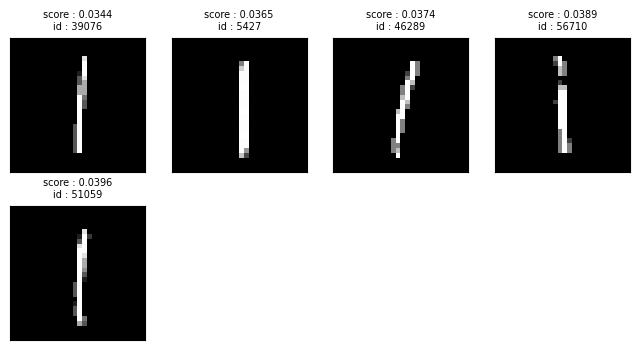

In [ ]:
lab.report()

### Проблемы с маркировкой


In [ ]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,False,0.999168,4,4
1,False,0.999894,1,1
2,False,1.000000,3,3
3,False,0.999989,4,4
4,False,0.999986,3,3


In [ ]:
label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
19967,True,4.733433e-08,4,7
42884,True,4.866340e-06,3,7
308,True,2.094401e-05,9,0
14367,True,2.796817e-05,8,1
22288,True,3.090353e-05,5,0


In [ ]:
def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

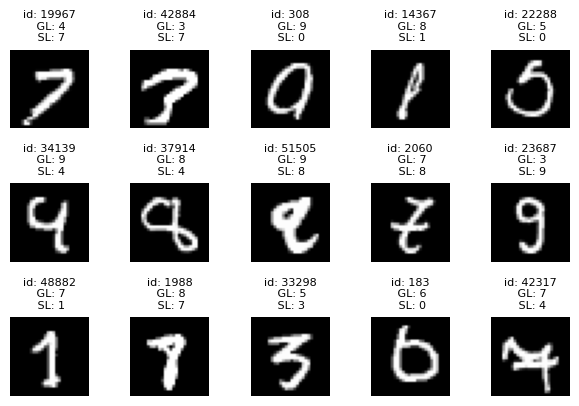

In [ ]:
plot_label_issue_examples(label_issues_df, num_examples=15)

В данном примере хорошо раскрывается проблема машинного обучения для распознования каптчи. Например, у примера с id 308 машина явно не поняла нижнюю линию как проделжение цифры 9, или на примере id 2060 не распознала цифру и приняла её за другую.

### Выбросы


In [ ]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df.query("is_outlier_issue").sort_values("outlier_score")
outlier_issues_df.head()

,is_outlier_issue,outlier_score
393,True,0.810537
45525,True,0.815343
58815,True,0.825679
1817,True,0.827899
28890,True,0.827947


#### Просмотр наиболее важных выбросов

В этой визуализации первое изображение в каждой строке показывает потенциальный выброс, а остальные изображения в той же строке изображают типичные экземпляры соответствующего класса.

In [ ]:
def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols = 4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    images_to_plot = []
    labels = []
    idlist = []
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        labels.append(label)
        idlist.append(idx)
        images_to_plot.append(image)
        images_to_plot.extend(comparison_images)
        count += 1
        if count >= nrows:
            break

    ncols = 1 + N_comparison_images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    for i, ax in enumerate(axes_list):
        if i % ncols == 0:
            ax.set_title(
                f"id: {idlist[i // ncols]}\n GL: {labels[i // ncols]}", fontdict={"fontsize": 8}
            )
        ax.imshow(images_to_plot[i], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

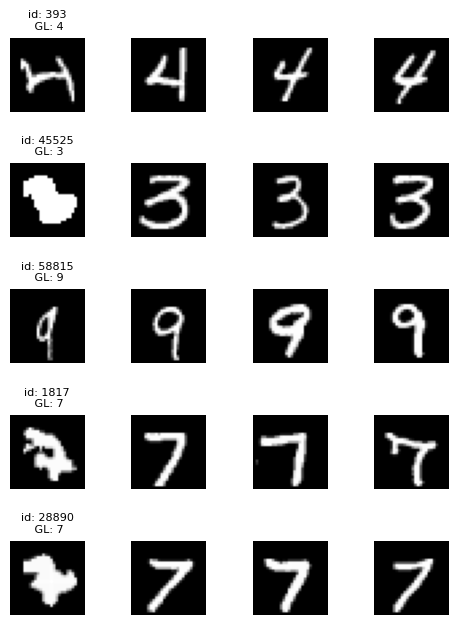

In [ ]:
plot_outlier_issues_examples(outlier_issues_df, num_examples=5)

Ярко показаны выбросы 3 и 7, на фоне которых выбросы 4 и 9 выглядят вплоне нормальнымы вариантами. 3 и нижняя 7 совершенно нечитаемы.

### Near duplicate issues
Проблемы с повторами

Datalab также определяет, какие примеры являются (почти) дубликатами других примеров в наборе данных. Почти повторяющиеся изображения в наборе данных могут привести к переобучению модели и оказать огромное влияние на показатели оценки (особенно если у вас есть дубликаты между обучающим и тестовым разделением).

DataFrame `near_duulate_issues` сообщает нам, какие примеры считаются почти повторяющимися в наборе данных (включая и точные дубликаты). Мы можем отсортировать все изображения с помощью параметра «near_duulate_score», который количественно определяет, насколько серьезна эта проблема для каждого изображения (более низкие значения указывают на более серьезные случаи определенного типа проблемы, в данном случае насколько изображение похоже на своего ближайшего соседа в наборе данных). .

Это позволяет нам визуализировать в наборе данных примеры, которые считаются практически повторяющимися, а также их очень похожие аналоги.

In [ ]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score"
)
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
22073,True,0.000620,[58670],0.000620
58670,True,0.000620,"[22073, 11300, 40092]",0.000620
34016,True,0.000908,[46353],0.000908
46353,True,0.000908,[34016],0.000908
15419,True,0.000985,"[17904, 55440, 17754, 29263]",0.000985


#### Просмотр наборов почти повторяющихся изображений

<details><summary>We define a helper method plot_near_duplicate_issue_examples to visualize results. **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()
```
</details>

In [ ]:
def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()

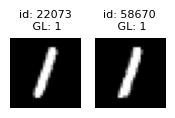

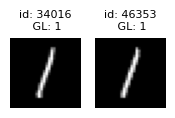

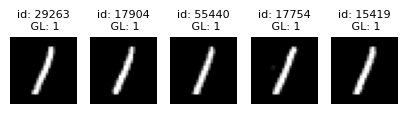

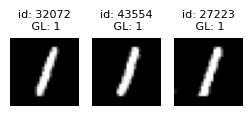

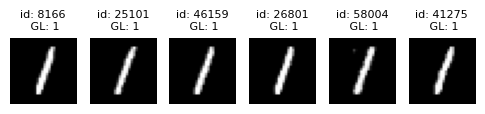

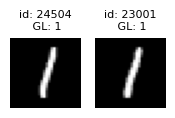

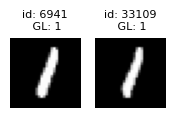

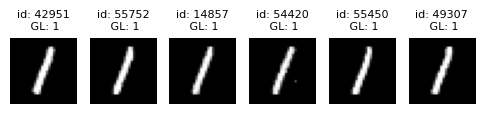

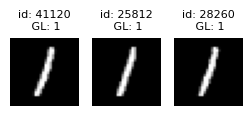

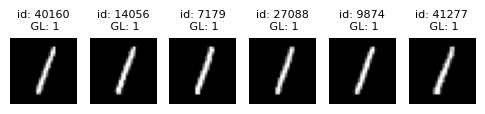

In [ ]:
plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=10)

На данном этапе машине кажется, что дубикатами выступает цифра 1, хотя это вполне не удивительно, так как она состоит из одной линии. Для меня интересен ещё факт цифры 7. На мой взгляд, машина может столкнуться с той же проблемой.

### Темные изображения

Datalab также может обнаруживать в наборе данных изображения низкого качества, например, аномально темные. Как аннотаторам, так и моделям может быть сложно назначить правильную метку класса для данных низкого качества, что может затруднить обучение и тестирование модели.

DataFrame `dark_issues` показывает, какие примеры считаются аномально темными. Мы можем отсортировать их с помощью параметра `dark_score`, который количественно определяет, насколько серьезна эта проблема для каждого изображения (более низкие значения указывают на более серьезные случаи того или иного типа проблемы). Это позволяет нам визуализировать изображения в наборе данных, которые считаются слишком темными (вы можете исключить такие примеры низкого качества из набора обучающих данных).

In [ ]:
dark_issues = lab.get_issues("dark")
dark_issues_df = dark_issues.query("is_dark_issue").sort_values("dark_score")
dark_issues_df.head()

,dark_score,is_dark_issue


Пустое поле говорит нам о том что темные изображения найдены не были. :(

### Изображения с низкой информативностью

Другие типы изображений низкого качества, которые Datalab может автоматически обнаружить, включают изображения с низкой информативностью. Малоинформативные изображения могут затруднить обобщение модели, если они присутствуют непропорционально в некоторых классах.

DataFrame `lowinfo_issues` показывает, какие изображения считаются малоинформативными. Мы можем отсортировать их с помощью параметра low_information_score, который количественно определяет, насколько серьезна эта проблема для каждого изображения (более низкие значения указывают на более серьезные случаи того или иного типа проблемы). Это позволяет нам визуализировать изображения в нашем наборе данных, содержащие наименьшее количество информации (вы можете исключить такие примеры низкого качества из набора обучающих данных).

In [ ]:
lowinfo_issues = lab.get_issues("low_information")
lowinfo_issues_df = lowinfo_issues.query("is_low_information_issue").sort_values(
    "low_information_score"
)
lowinfo_issues_df.head()

,is_low_information_issue,low_information_score
39076,True,0.034367
5427,True,0.036549
46289,True,0.037395
56710,True,0.038860
51059,True,0.039648


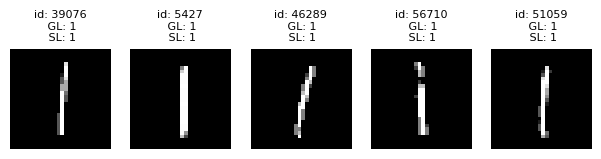

In [ ]:
plot_image_issue_examples(lowinfo_issues_df, num_examples=5)

На данном изображении видны провалы в рисунках, из-за чего есть вероятность ошибки классификации.